## Scattering of a plane wave by a hexagon
This is a (hopefully) simple script for computing the scattering of a plane wave by a penetrable hexagon using the 2D DDA version of the volume integral equation method.

In [1]:
# Import packages
import os
import sys
# FIXME: avoid this sys.path stuff
sys.path.append(os.path.join(os.path.abspath(''), '../../'))
import numpy as np
from scipy.sparse.linalg import LinearOperator, gmres
from analytical import penetrable_circle
from scipy.linalg import toeplitz
import time
from vines.geometry.geometry import shape_2d, generatedomain2d
from vines.operators.acoustic_operators import get_operator_2d, circulant_embedding
from vines.fields.plane_wave import PlaneWave_2d
from vines.operators.acoustic_matvecs import mvp_2d
from vines.precondition.circulant_acoustic import mvp_circ_2d, circulant_preconditioner

### Introduction to the volume integral equation method
The boundary value problem we wish to solve is:

Given a complex refractive index $\mu(x)\in\mathbb{C}$, incident wave $u^{\text{inc}}$ and wavenumber $k\in\mathbb{R}$, find the scattered field $u^{\text{sca}}$ such that
$$
    (\nabla^2 + (\mu(x) k)^2)u^{\text{sca}}(x) = -(\nabla^2 + (\mu(x) k)^2)u^{\text{inc}}(x).
$$

The incident wave satisfies the Helmholtz equation with the wavenumber $k$, so the right-hand side can be simplified to yield
$$
    (\nabla^2 + (\mu(x) k)^2)u^{\text{sca}}(x) = -(\mu(x)^2-1) k^2u^{\text{inc}}(x).
$$
This tells us that the scattered field is generated by regions in which $\mu(x)\neq 1$, as we should expect. Let us suppose that we have one closed region $V$ in which $\mu(x)\neq 1$. Then it can be shown that the total field $u:=u^{\text{inc}}+u^{\text{sca}}$ satisfies the following volume integral equation:
$$
    u(x) - k^2\int_{V}G(x,y)(\mu(y)^2-1)u(y)\text{d}y = u^{\text{inc}}(x),
$$
where $G$ is Green's function:
$$
    G(x, y) = \frac{i}{4}H_0^{(1)}(k|x-y|), \quad x\neq y, \quad \text{in two dimensions.}
$$

In [2]:
# Set problem parameters and discretization resolution
ko = 60          # wavenumber
refInd = 1.31     # refractive index
shape = 'hex'    # choose shape (hex, circle, ellipse)
radius = 1       # radius of shape
n_per_lam = 10   # number of points per wavelength
angle = 0  # Incident wave angle to x-axis
d_inc = np.array([np.cos(angle), np.sin(angle)])

In [3]:
lambda_ext = 2 * np.pi / ko  # wavelength
# Generate grid points (r), indices of interior points (idx), pixel size (dx), shape vertices (verts), interior wavelength (lambda_int)
r, idx, dx, verts, lambda_int = shape_2d('hex', refInd, lambda_ext, radius, n_per_lam)

M, N, _ = r.shape  # number of voxels in x,y directions (M, N, respectively)

In [4]:
# Get Toeplitz operator
a = np.sqrt(dx**2 / np.pi)  # radius of equivalent area circle
toep = get_operator_2d(dx**2, ko, r, a)

In [5]:
# Circulant embedding of Toeplitz matrix (required for FFT matvec)
opCirc = circulant_embedding(toep, M ,N)

In [6]:
# Set up the mu^2-1 matrix, call it MR
mu_sq = np.ones((M, N))
mu_sq[idx] = refInd ** 2
MR = mu_sq - 1

In [7]:
# Define matrix-vector product and corresponding linear operator
mvp = lambda x: mvp_2d(x, opCirc, idx, MR)

A = LinearOperator((M*N, M*N), matvec=mvp)

In [8]:
# Construct circulant approximation of Toeplitz matrix in x-direction
start = time.time()
circ_inv = circulant_preconditioner(toep, M, N, refInd)
end = time.time()
print('Preconditioner assembly time = ', end - start)

Preconditioner assembly time =  0.9989569187164307


In [9]:
# Import matrix-vector product with circulant preconditioner and establish preconditioner operator
mvp_prec = lambda x: mvp_circ_2d(x, circ_inv, M, N, idx)
prec = LinearOperator((M*N, M*N), matvec=mvp_prec)

In [10]:
# Assemble right-hand side (u_inc). Use a plane wave.
u_inc = PlaneWave_2d(1, ko, d_inc, r)

# Create an array that equals the incident field inside the scatterer and is zero outside
rhs = np.zeros((M, N), dtype=np.complex128)
rhs[idx] = u_inc[idx]
rhs_vec = rhs.reshape((M*N, 1), order='F')

In [11]:
# Perform iterative solve
it_count = 0

def iteration_counter(x):
    global it_count
    it_count += 1

start = time.time()
solp, info = gmres(A, rhs_vec, M=prec, tol=1e-5, callback=iteration_counter)
end = time.time()
print("The linear system was solved in {0} iterations".format(it_count))
print("Solve time {0} seconds".format(end-start))

The linear system was solved in 80 iterations
Solve time 3.8721978664398193 seconds


### Evaluating the field everywhere
The solution we have obtained lives only on the scatterer. In order to evaluate the scattered field (and hence total field) throughout the domain, we can rearrange our original integral equation to give the following representation for the scattered field:
$$
    u^{\text{sca}}(x) = k^2\int_V G(x, y)(\mu^2(y)-1)u(y)\text{d}y.
$$
That is, we require one matrix-vector product to compute the scattered field.

In [12]:
from vines.operators.acoustic_matvecs import scattered_field
# Scattered field
u_sca = scattered_field(solp, opCirc, M, N, MR)
# Total field
u = u_inc + u_sca

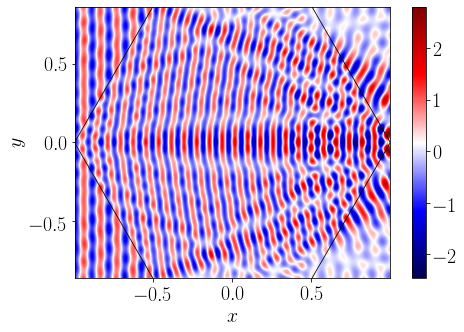

In [13]:
# Plot the field
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
matplotlib.rcParams.update({'font.size': 20})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig = plt.figure(figsize=(8, 5))
ax = fig.gca()
plt.imshow(np.real(u.T), extent=[r[0, 0, 0], r[-1, 0, 0], r[0, 0, 1], r[0, -1, 1]],
           cmap=plt.cm.get_cmap('seismic'), interpolation='spline16')

polygon = Polygon(verts, facecolor="none", 
              edgecolor='black', lw=0.8)
plt.gca().add_patch(polygon)

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.colorbar()
plt.show()

### Evaluate over a larger domain
What if we want to evaluate the field over a region that is larger than the original computation domain, which was the smallest bounding box around the hexagon? This is doable but requires the creation of a new grid and a new (Toeplitz) operator on this grid. For efficiency, it makes sense to ensure that the original grid sits within the new grid and that the pixels are the same size.

In [14]:
# First set up variables for the dimensions of bounding-box computational domain
wx = r[-1, 0, 0] - r[0, 0, 0] + dx
wy = r[0, -1, 1] - r[0, 0, 1] + dx

In [15]:
# Create a larger domain for field evaluation
# Let's make the new domain the original one previous plus a border or width w_extra
w_extra = lambda_ext * 20
# Now adjust to make sure pixels of new ones will equal the original ones
nn = np.ceil(w_extra / dx)
wx_big = 2 * nn * dx + wx
wy_big = 2 * nn * dx + wy

r_big, M_big, N_big = generatedomain2d(dx, wx_big, wy_big)

In [16]:
# Find pixels inside original computation domain
idx_eval = (r_big[:, :, 0] > r[0, 0, 0] - dx/2) * \
        (r_big[:, :, 0] < r[-1, 0, 0] + dx/2) * \
        (r_big[:, :, 1] > r[0, 0, 1] - dx/2) * \
        (r_big[:, :, 1] < r[0, -1, 1] + dx/2)

In [17]:
# Get Toeplitz operator on new domain
toep_big = get_operator_2d(dx**2, ko, r_big, a)
# Circulant embedding of Toeplitz matrix
opCirc_big = circulant_embedding(toep_big, M_big, N_big)

In [18]:
# Next create the refractive index matrix
mu_sq_big = np.ones((M_big, N_big))
mu_sq_big[idx_eval] = mu_sq.reshape(M*N, 1)[:, 0]
MR_big = mu_sq_big - 1

In [21]:
# Create a new solution matrix that contains the original solution at the correct locations
u_sol_big = np.zeros((M_big, N_big), dtype=np.complex128)
u_sol = solp.reshape(M, N, order='F')
u_sol_big[idx_eval] = u_sol.reshape(M*N, 1)[:, 0]

In [22]:
# Evaluate incident field on new grid
u_inc_big = PlaneWave_2d(1, ko, d_inc, r_big)

In [23]:
# Convert u_sol_big into vector
solp_eval = u_sol_big.reshape((M_big*N_big, 1), order='F')
# Scattered field
u_sca_big = scattered_field(solp_eval, opCirc_big, M_big, N_big, MR_big)
# Total field
u_big = u_inc_big + u_sca_big

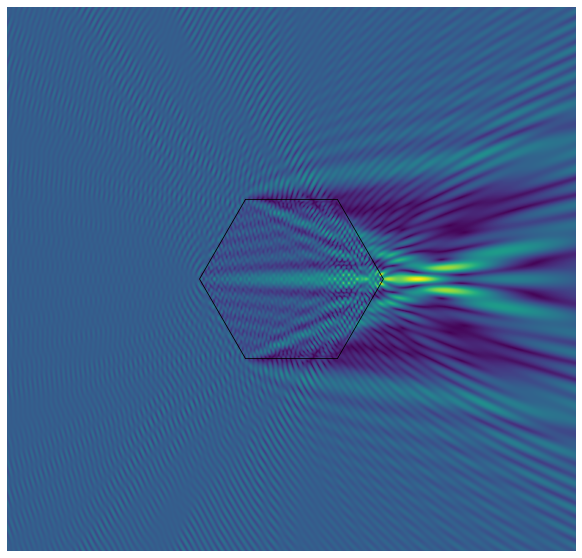

In [24]:
matplotlib.rcParams.update({'font.size': 20})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig = plt.figure(figsize=(16, 10))
ax = fig.gca()
plt.imshow(np.abs(u_big.T), extent=[r_big[0, 0, 0], r_big[-1, 0, 0], r_big[0, 0, 1], r_big[0, -1, 1]],
           cmap=plt.cm.get_cmap('viridis'), interpolation='spline16')

polygon = Polygon(verts, facecolor="none", 
              edgecolor='black', lw=0.8)
plt.gca().add_patch(polygon)
plt.axis('off')
fig.savefig('results/hex_abs.png')
# plt.xlabel('$x$')
# plt.ylabel('$y$')
# plt.colorbar()

### Far-field pattern
For many applications, it is the far-field pattern that is of primary interest. The scattered field has the asymptotic (large $kr$) behaviour
$$
    u^s(x) = \frac{e^{ik|x|}}{|x|^{(d-1)/2}}\left(u_{\infty}(\hat{x})+\mathcal{O}\left(\frac{1}{|x|})\right)\right),
$$
uniformly with respect to $\hat{x}\in\mathcal{S}^{d-1}$, where the *far-field pattern* $u_{\infty}(\cdot)$ is given by
$$
    u_{\infty}(\hat{x}) = c_d k^2\int_V(\mu(y)^2-1)e^{-ik\hat{x}\cdot y}u(y)\text{d}y,
$$
with 
$$
    c_d = 
    \begin{cases}
        \frac{e^{i\pi/4}}{\sqrt{8\pi k}}\ & d=2, \\
        \frac{1}{4\pi}\ & d=3.
    \end{cases}
$$

In [40]:
def far_field(angle_inc, theta, r, ko, MR, u_sol):
    # theta = np.linspace(0, 2 * np.pi, n+1)
    n = len(theta)
    x_hat = np.array([np.cos(theta+angle_inc), np.sin(theta+angle_inc)])
    ffp = np.zeros((n, 1), dtype=np.complex128)
    for i in range(n):
        dot_prod = x_hat[0, i] * r[:, :, 0] + x_hat[1, i] * r[:, :, 1]
        exp = np.exp(-1j * ko * dot_prod)
        ffp[i] = np.sum(MR * exp * u_sol)

    c_d = np.exp(1j*np.pi/4) / np.sqrt(8*np.pi*ko)
    ffp *= c_d
    return ffp

In [53]:
# Evaluate far field in n evenly spaced directions between angles 0 and 180 degrees
n = 180 * 2
theta_ffp = np.linspace(0, np.pi, n)
ffp = far_field(angle, theta_ffp, r, ko, MR, u_sol)

Text(0, 0.5, '$|u_{\\infty}|$')

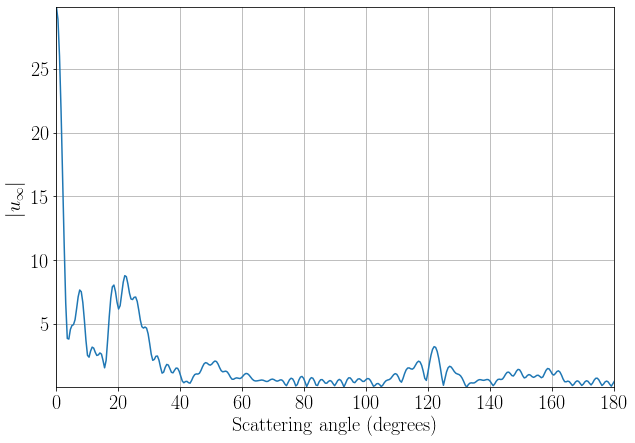

In [84]:
fig = plt.figure(figsize=(10, 7))
ax = fig.gca()
plt.plot(theta_ffp[:] * 180 / np.pi, np.abs(ffp[:]))
plt.grid('on')
plt.autoscale(enable=True, axis='both', tight=True)
plt.xlabel('Scattering angle (degrees)')
plt.ylabel('$|u_{\infty}|$')

### Random orientation
Now let's consider a hexagon in random orientation. In order to compute the far-field pattern of a randomly-oriented hexagon, we simple average many far-field patterns for different incident wave directions. Owing to the symmetry of the hexagon, we need only consider incident angles between 0 and 60 degrees (actually, 30 degrees would suffice but 0 to 60 is easier to implement).

In [90]:
# Discretise (0, 60) degrees uniformly into n_angles angles
n_angles = 10
angles = np.linspace(0, np.pi/3, n_angles + 1)

For each incident angle we need to solve the linear system with the appropriate right-hand side and then compute the far-field pattern. This means we do not need to reassemble the matrix-operator, but just the right-hand side and then perform the iterative solve.

In [91]:
FFP = np.zeros((n_angles, n), dtype=np.complex128)
for i_angle in range(n_angles):
    # Assemble right-hand side
    d_inc = np.array([np.cos(angles[i_angle]), np.sin(angles[i_angle])])
    u_inc = PlaneWave_2d(1, ko, d_inc, r)
    rhs = np.zeros((M, N), dtype=np.complex128)
    rhs[idx] = u_inc[idx]
    rhs_vec = rhs.reshape((M*N, 1), order='F')
    # Solve linear system
    it_count = 0
    start = time.time()
    solp, info = gmres(A, rhs_vec, M=prec, tol=1e-4, callback=iteration_counter)
    end = time.time()
    print("The linear system was solved in {0} iterations".format(it_count))
    print("Solve time {0} seconds".format(end-start))
    u_sol = solp.reshape(M, N, order='F')
    # ffp, theta = far_field(angles[i_angle], n, r, ko, MR, u_sol)
    ffp = far_field(angles[i_angle], theta_ffp, r, ko, MR, u_sol)
    FFP[i_angle, :] = ffp[:, 0]

The linear system was solved in 60 iterations
Solve time 2.0912587642669678 seconds
The linear system was solved in 91 iterations
Solve time 3.0414559841156006 seconds
The linear system was solved in 94 iterations
Solve time 3.1104252338409424 seconds
The linear system was solved in 92 iterations
Solve time 2.7956202030181885 seconds
The linear system was solved in 95 iterations
Solve time 3.170588970184326 seconds
The linear system was solved in 100 iterations
Solve time 3.291443109512329 seconds
The linear system was solved in 88 iterations
Solve time 2.896496057510376 seconds
The linear system was solved in 93 iterations
Solve time 3.1029350757598877 seconds
The linear system was solved in 94 iterations
Solve time 3.11686110496521 seconds
The linear system was solved in 80 iterations
Solve time 2.4282162189483643 seconds


In [93]:
# Calculate an averaged far-field pattern
ffp_mean = np.sum(FFP, axis=0) / n_angles

Text(0, 0.5, '$|u_{\\infty}|$')

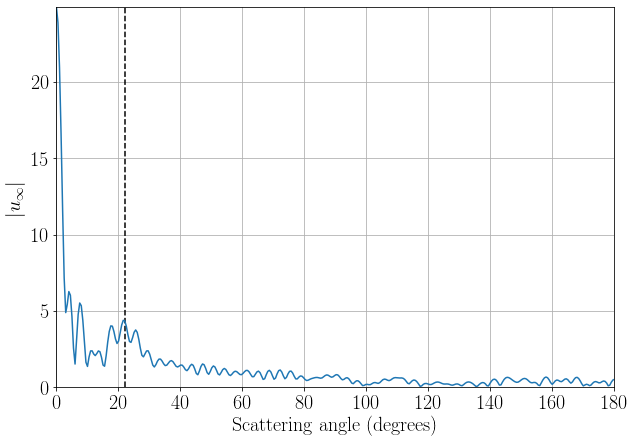

In [94]:
# Plot the FFP for randomly-oriented hexagon. The 22 degree halo is indicated by the dashed line.
fig = plt.figure(figsize=(10, 7))
ax = fig.gca()
plt.plot(theta_ffp * 180/np.pi, np.abs(ffp_mean))
plt.vlines(22, 0, np.max(np.abs(ffp_mean)), 'k', 'dashed')
plt.grid('on')
plt.autoscale(enable=True, axis='both', tight=True)
plt.xlabel('Scattering angle (degrees)')
plt.ylabel('$|u_{\infty}|$')

In [102]:
# Identify the precise angle of the "22 degree" halo
# First crop off the first 15 degrees worth of values since they are dominant
ffp_crop = ffp_mean[30:]
theta_crop = theta_ffp[30:]
# Max value index
ind_max = np.argmax(np.abs(ffp_crop))
print('Halo is located at ' + str.format('{0:.2f}', theta_crop[ind_max] * 180 / np.pi) + ' degrees.')

Halo is located at 21.56 degrees.
